In [87]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.frequent_patterns import apriori, association_rules
from prefixspan import PrefixSpan
import os
import matplotlib.pyplot as plt


torch.manual_seed(2025) #set seed

In [88]:
# load dataset
df = pd.read_csv("/home/bedoo/NLP_HuggingFace/Student-learning-Recommandation/synthetic_elearning_logs.csv")

In [89]:
df.head(5)

,Student_ID,Session_ID,Timestamp,Activity_Type,Outcome
0,1,14,2024-01-01 01:52:00,Read Material,Success
1,1,44,2024-01-01 02:26:00,Forum Discussion,Failure
2,1,193,2024-01-01 03:12:00,Watch Video,Failure
3,1,89,2024-01-01 03:50:00,Attempt Quiz,Completed
4,1,239,2024-01-01 04:34:00,Request Hint,Completed


In [90]:
# Group interactions by Student_ID to create learning sequences
student_traces = df.groupby("Student_ID")["Activity_Type"].apply(lambda x: " -> ".join(x)).reset_index()

# Convert sequences into numerical features using TF-IDF (text-based approach)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(student_traces["Activity_Type"]).toarray()

In [91]:
# Apply Hierarchical Agglomerative Clustering (HAC) to group similar learning patterns
num_clusters = 5  # Define number of clusters
clustering_model = AgglomerativeClustering(n_clusters=num_clusters, linkage="ward")
student_traces["Cluster"] = clustering_model.fit_predict(X)

# Convert sequences into list format for PrefixSpan
sequences = [trace.split(" -> ") for trace in student_traces["Activity_Type"]]
print(sequences) 

[['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Request Hint', 'Read Material', 'Submit Assignment', 'Request Hint', 'Submit Assignment', 'Attempt Quiz', 'Watch Video', 'Read Material', 'Forum Discussion', 'Watch Video', 'Watch Video', 'Watch Video', 'Submit Assignment', 'Request Hint', 'Attempt Quiz', 'Submit Assignment', 'Watch Video', 'Forum Discussion', 'Attempt Quiz', 'Request Hint', 'Request Hint', 'Read Material'], ['Request Hint', 'Attempt Quiz', 'Submit Assignment', 'Attempt Quiz', 'Request Hint', 'Read Material', 'Watch Video', 'Request Hint', 'Request Hint', 'Attempt Quiz', 'Attempt Quiz', 'Forum Discussion', 'Request Hint', 'Read Material', 'Read Material', 'Forum Discussion', 'Watch Video', 'Read Material', 'Submit Assignment', 'Attempt Quiz', 'Submit Assignment', 'Read Material', 'Request Hint'], ['Read Material', 'Read Material', 'Forum Discussion', 'Forum Discussion', 'Request Hint', 'Forum Discussion', 'Read Material', 'Request Hint', 'Request Hi

In [92]:
# Apply PrefixSpan for Frequent Subsequence Encoding (FSS-Encoding)
ps = PrefixSpan(sequences)
ps.minlen = 2  # Minimum length of subsequence
ps.maxlen = 5  # Maximum length of subsequence
frequent_patterns = ps.frequent(10)  # Get top 10 frequent patterns

In [93]:
# Display frequent patterns
print("Frequent Subsequence Patterns:")
for pattern in frequent_patterns:
    print(pattern)

Frequent Subsequence Patterns:
(91, ['Read Material', 'Forum Discussion'])
(71, ['Read Material', 'Forum Discussion', 'Watch Video'])
(47, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz'])
(34, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Request Hint'])
(27, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Read Material'])
(27, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Submit Assignment'])
(31, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Attempt Quiz'])
(29, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Watch Video'])
(25, ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz', 'Forum Discussion'])
(52, ['Read Material', 'Forum Discussion', 'Watch Video', 'Request Hint'])
(27, ['Read Material', 'Forum Discussion', 'Watch Video', 'Request Hint', 'Read Material'])
(28, ['Read Material', 'Forum Discussion', 'Watch Video', 'Request Hi

## LSTM Model

In [94]:
# Define a simple recommendation system using PyTorch
class RecommendationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RecommendationModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [95]:
# Example usage: Train on synthetic sequence embeddings
input_size = X.shape[1]
# print(input_size)
hidden_size = 128
output_size = len(vectorizer.get_feature_names_out())
# print(output_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecommendationModel(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [96]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.randint(0, output_size, (X.shape[0],)).to(device) 
# print(y_tensor) # Dummy labels

In [97]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('results/loss_plot.png')
    plt.show()

In [98]:
import csv

epoch 0: train loss 2.0878 | val loss 2.0873
epoch 100: train loss 2.0213 | val loss 2.0203
epoch 200: train loss 1.8756 | val loss 1.8737
epoch 300: train loss 1.6558 | val loss 1.6534
epoch 400: train loss 1.4105 | val loss 1.4080
epoch 500: train loss 1.1598 | val loss 1.1573
epoch 600: train loss 0.9229 | val loss 0.9206
epoch 700: train loss 0.7164 | val loss 0.7146
epoch 800: train loss 0.5455 | val loss 0.5440
epoch 900: train loss 0.4106 | val loss 0.4094
epoch 1000: train loss 0.3083 | val loss 0.3074
epoch 1100: train loss 0.2323 | val loss 0.2316
epoch 1200: train loss 0.1762 | val loss 0.1757
epoch 1300: train loss 0.1349 | val loss 0.1345
epoch 1400: train loss 0.1044 | val loss 0.1041
epoch 1500: train loss 0.0819 | val loss 0.0817
epoch 1600: train loss 0.0652 | val loss 0.0651
epoch 1700: train loss 0.0527 | val loss 0.0525
epoch 1800: train loss 0.0431 | val loss 0.0430
epoch 1900: train loss 0.0358 | val loss 0.0357
epoch 2000: train loss 0.0300 | val loss 0.0300
epoc

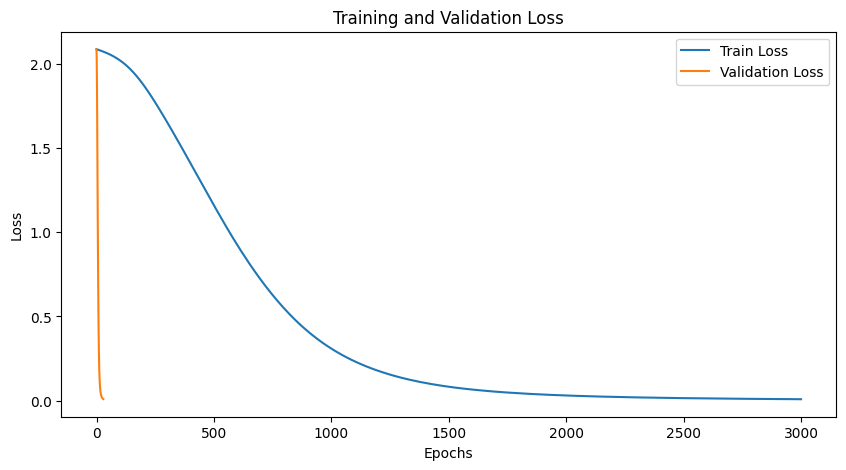

In [103]:
if __name__ == "__main__":
    #### Create the result files ####
    if not os.path.exists('results'):
        os.makedirs('results')
    with open('results/losses.csv', 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss'])
    
    train_losses = []
    val_losses = []
    epochs = 3000
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(X_tensor.unsqueeze(1))
        loss = criterion(logits, y_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if epoch % 100 == 0:
            val_loss = criterion(model(X_tensor.unsqueeze(1)), y_tensor).item()
            print(f"epoch {epoch}: train loss {loss.item():.4f} | val loss {val_loss:.4f}")
            val_losses.append(val_loss)
            with open('results/losses.csv', 'a') as f:
                csv_writer = csv.writer(f)
                csv_writer.writerow([epoch, loss.item(), val_loss])
        # Save the trained model
    model_save_path = "results/recommendation_model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    
    plot_loss(train_losses, val_losses)

In [110]:
model_save_path ="/home/bedoo/NLP_HuggingFace/Student-learning-Recommandation/Recoomandation.ipynb" 

In [101]:
#   # Load and test the saved model
# model.load_state_dict(torch.load(model_save_path))
# model.eval()
# with torch.no_grad():
#     sample_input = X_tensor[:1].unsqueeze(1)
#     prediction = model(sample_input) 
#     print(prediction) # Select a sample student sequence
#     prediction = model(sample_input)
#     predicted_label = torch.argmax(prediction, dim=1).item()
#     predicted_action = vectorizer.get_feature_names_out()[predicted_label]
#     print(f"Predicted next action category: {predicted_label}")
#     print(f"Predicted next action: {predicted_action}")

    

In [112]:
model.load_state_dict(torch.load("results/recommendation_model.pth"))
model.eval()
with torch.no_grad():
    sample_input = X_tensor[1: 1+1].unsqueeze(1)  # Select a sample student sequence
    prediction = model(sample_input)
    predicted_label = torch.argmax(prediction, dim=1).item()
    predicted_action = vectorizer.get_feature_names_out()[predicted_label]
    sample_words = student_traces.loc[0, "Activity_Type"]  # Retrieve original sequence as words
    print(f"Sample sequence: {sample_words}")
    print(f"Predicted next action: {predicted_action}")

Sample sequence: Read Material -> Forum Discussion -> Watch Video -> Attempt Quiz -> Request Hint -> Read Material -> Submit Assignment -> Request Hint -> Submit Assignment -> Attempt Quiz -> Watch Video -> Read Material -> Forum Discussion -> Watch Video -> Watch Video -> Watch Video -> Submit Assignment -> Request Hint -> Attempt Quiz -> Submit Assignment -> Watch Video -> Forum Discussion -> Attempt Quiz -> Request Hint -> Request Hint -> Read Material
Predicted next action: quiz


/tmp/ipykernel_1456167/3707089158.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/recommendation_model.pth"))


In [113]:
with torch.no_grad():
    prediction = model(sample_input)
    probabilities = torch.nn.functional.softmax(prediction, dim=1).cpu().numpy()
    
    # Get top predicted actions
    top_3_indices = probabilities.argsort()[0][-3:][::-1]  # Get top 3 predictions
    top_3_actions = [vectorizer.get_feature_names_out()[i] for i in top_3_indices]
    
    print(f"Top 3 Predicted Actions: {top_3_actions}")


Top 3 Predicted Actions: ['quiz', 'discussion', 'hint']


In [108]:
custom_sequence = ['Read Material', 'Forum Discussion', 'Watch Video', 'Attempt Quiz']  # Example learning path
custom_sequence_str = " -> ".join(custom_sequence)

# Convert the custom sequence into TF-IDF representation
custom_vector = vectorizer.transform([custom_sequence_str]).toarray()
custom_tensor = torch.tensor(custom_vector, dtype=torch.float32).unsqueeze(0).to(device)  # Convert to tensor

# Make a prediction
model.eval()
with torch.no_grad():
    prediction = model(custom_tensor)  # Add batch dimension
    predicted_label = torch.argmax(prediction, dim=1).item()
    predicted_action = vectorizer.get_feature_names_out()[predicted_label]

print(f"Custom Input Sequence: {custom_sequence_str}")
print(f"Predicted Next Action: {predicted_action}")


Custom Input Sequence: Read Material -> Forum Discussion -> Watch Video -> Attempt Quiz
Predicted Next Action: watch


In [109]:
# Step 1: Get the actual next action from dataset
student_id = 1 # Example student index
actual_sequence = student_traces.loc[student_id, "Activity_Type"].split(" -> ")  # Extract sequence
actual_next_action = actual_sequence[len(custom_sequence)] if len(actual_sequence) > len(custom_sequence) else "Unknown"

# Step 2: Get model's predicted next action
model.eval()
with torch.no_grad():
    prediction = model(custom_tensor)
    predicted_label = torch.argmax(prediction, dim=1).item()
    predicted_action = vectorizer.get_feature_names_out()[predicted_label]

# Step 3: Compare the actual action with the prediction
print(f"Actual Next Action: {actual_next_action}")
print(f"Predicted Next Action: {predicted_action}")

# Step 4: Check if the prediction is correct
if predicted_action == actual_next_action:
    print("✅ Model predicted correctly!")
else:
    print("❌ Model made an incorrect prediction.")


Actual Next Action: Request Hint
Predicted Next Action: watch
❌ Model made an incorrect prediction.


## Multi head Attention

In [131]:
block_size = 128  # Fixed sequence length

def pad_or_truncate(sequence, block_size):
    """Ensures all input sequences have a fixed length."""
    seq_len = sequence.shape[1]
    if seq_len < block_size:
        # Pad with zeros
        padding = torch.zeros((sequence.shape[0], block_size - seq_len, sequence.shape[2]), device=sequence.device)
        sequence = torch.cat([sequence, padding], dim=1)
    elif seq_len > block_size:
        # Truncate to fixed length
        sequence = sequence[:, :block_size, :]
    return sequence


In [136]:
# Define a recommendation model with Stacked Multi-Head Attention Blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.block_size = block_size 
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.ReLU(),
            nn.Linear(4 * hidden_size, hidden_size),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = pad_or_truncate(x, self.block_size)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

In [137]:
class RecommendationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads=4, num_layers=6, block_size=128):
        super(RecommendationModel, self).__init__()
        self.block_size = block_size  # Set fixed sequence length
        self.embedding = nn.Linear(input_size, hidden_size)
        self.attention_blocks = nn.Sequential(*[AttentionBlock(hidden_size, num_heads, block_size) for _ in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = pad_or_truncate(x, self.block_size)  # Ensure sequence length is fixed
        x = self.embedding(x)  
        x = self.attention_blocks(x)  
        output = self.fc(x[:, -1, :])  # Get last timestep output
        return output


In [139]:
# Example usage: Train on synthetic sequence embeddings
input_size = X.shape[1]
hidden_size = 128
output_size = len(vectorizer.get_feature_names_out())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecommendationModel(input_size, hidden_size, output_size,  num_heads=4, num_layers=6, block_size=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.randint(0, output_size, (X.shape[0],)).to(device)  # Dummy labels

ValueError: dropout probability has to be between 0 and 1, but got 128

epoch 0: train loss 2.5686 | val loss 2.7954
epoch 20: train loss 1.8976 | val loss 1.8499
epoch 40: train loss 1.0837 | val loss 1.0148
epoch 60: train loss 0.3550 | val loss 0.3683
epoch 80: train loss 0.0417 | val loss 0.0748
Model saved to results/recommendationHead_model.pth


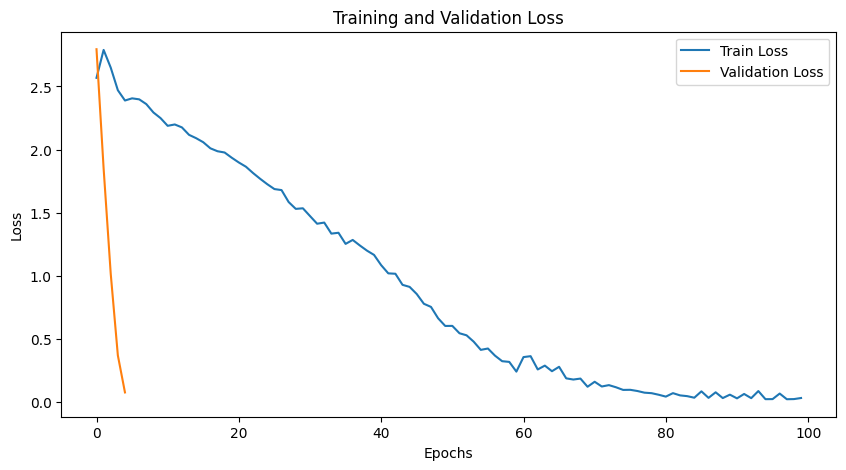

In [126]:
if __name__ == "__main__":
    #### Create the result files ####
    if not os.path.exists('results'):
        os.makedirs('results')
    with open('results/loss.csv', 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss'])
    
    train_losses = []
    val_losses = []
    epochs = 100
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(X_tensor.unsqueeze(1))
        loss = criterion(logits, y_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if epoch % 20 == 0:
            val_loss = criterion(model(X_tensor.unsqueeze(1)), y_tensor).item()
            print(f"epoch {epoch}: train loss {loss.item():.4f} | val loss {val_loss:.4f}")
            val_losses.append(val_loss)
            with open('results/loss.csv', 'a') as f:
                csv_writer = csv.writer(f)
                csv_writer.writerow([epoch, loss.item(), val_loss])
    
    # Save the trained model
    model_save_path = "results/recommendationHead_model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    
    plot_loss(train_losses, val_losses)

In [127]:
model_save_path1 = "/home/bedoo/NLP_HuggingFace/Student-learning-Recommandation/results/recommendationHead_model.pth"

In [128]:
model.load_state_dict(torch.load(model_save_path1))
model.eval()
with torch.no_grad():
    sample_input = X_tensor[5:5 +1].unsqueeze(1)  # Select a sample student sequence
    prediction = model(sample_input)
    predicted_label = torch.argmax(prediction, dim=1).item()
    predicted_action = vectorizer.get_feature_names_out()[predicted_label]
    sample_words = student_traces.loc[0, "Activity_Type"]  # Retrieve original sequence as words
    print(f"Sample sequence: {sample_words}")
    print(f"Predicted next action: {predicted_action}")

Sample sequence: Read Material -> Forum Discussion -> Watch Video -> Attempt Quiz -> Request Hint -> Read Material -> Submit Assignment -> Request Hint -> Submit Assignment -> Attempt Quiz -> Watch Video -> Read Material -> Forum Discussion -> Watch Video -> Watch Video -> Watch Video -> Submit Assignment -> Request Hint -> Attempt Quiz -> Submit Assignment -> Watch Video -> Forum Discussion -> Attempt Quiz -> Request Hint -> Request Hint -> Read Material
Predicted next action: request


/tmp/ipykernel_1456167/1287922998.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path1))


In [130]:
with torch.no_grad():
    prediction = model(sample_input)
    probabilities = torch.nn.functional.softmax(prediction, dim=1).cpu().numpy()
    
    # Get top predicted actions
    top_3_indices = probabilities.argsort()[0][-3:][::-1]  # Get top 3 predictions
    top_3_actions = [vectorizer.get_feature_names_out()[i] for i in top_3_indices]
    
    print(f"Top 3 Predicted Actions: {top_3_actions}")

Top 3 Predicted Actions: ['request', 'attempt', 'submit']


In [129]:
# Step 1: Get the actual next action from dataset
student_id = 1 # Example student index
actual_sequence = student_traces.loc[student_id, "Activity_Type"].split(" -> ")  # Extract sequence
actual_next_action = actual_sequence[len(custom_sequence)] if len(actual_sequence) > len(custom_sequence) else "Unknown"

# Step 2: Get model's predicted next action
model.eval()
with torch.no_grad():
    prediction = model(custom_tensor)
    predicted_label = torch.argmax(prediction, dim=1).item()
    predicted_action = vectorizer.get_feature_names_out()[predicted_label]

# Step 3: Compare the actual action with the prediction
print(f"Actual Next Action: {actual_next_action}")
print(f"Predicted Next Action: {predicted_action}")

# Step 4: Check if the prediction is correct
if predicted_action == actual_next_action:
    print("✅ Model predicted correctly!")
else:
    print("❌ Model made an incorrect prediction.")


Actual Next Action: Request Hint
Predicted Next Action: submit
❌ Model made an incorrect prediction.
